In [327]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [328]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [329]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from IPython.display import display, clear_output

def validate_with_optical_flow(input_path, model, device, output_dir='valid_frames',
                             threshold=0.5, mag_threshold=2.5, 
                             max_frames=100, pixel_spacing=0.1, lv_length=10.0):
    """
    Validate segmentation consistency using optical flow between consecutive masks
    and calculate ejection fraction from valid frames
    """
    os.makedirs(output_dir, exist_ok=True)
    cap = cv2.VideoCapture(input_path)
    
    model.eval()
    frame_count = 0
    prev_mask = None
    valid_frames = []
    validation_metrics = []
    mask_areas = []  # Store mask areas for EF calculation
    
    # For visualization
    plt.figure(figsize=(18, 6))
    
    with torch.no_grad():
        while cap.isOpened() and frame_count < max_frames:
            ret, frame = cap.read()
            if not ret:
                break
                
            # Convert and predict
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame_tensor = torch.from_numpy(frame_gray/255.).unsqueeze(0).unsqueeze(0).float().to(device)
            pred = model(frame_tensor)
            curr_mask = (pred > threshold).squeeze().cpu().numpy().astype(np.uint8)
            
            # Save current mask area (in pixels)
            current_area = np.sum(curr_mask)
            mask_areas.append(current_area)
            
            metrics = {
                'frame': frame_count,
                'mean_magnitude': 0,
                'is_valid': False,
                'mask_area': current_area
            }
            
            if prev_mask is not None:
                # Compute optical flow between masks
                prev_mask_flow = (prev_mask * 255).astype(np.uint8)
                curr_mask_flow = (curr_mask * 255).astype(np.uint8)
                flow = cv2.calcOpticalFlowFarneback(
                    prev_mask_flow, curr_mask_flow,
                    None, 0.5, 3, 15, 3, 5, 1.2, 0
                )
                
                # Get flow only within current mask region
                y, x = np.where(curr_mask == 1)
                if len(y) > 0:
                    flow_vectors = flow[y, x]
                    magnitude, _ = cv2.cartToPolar(flow_vectors[...,0], flow_vectors[...,1])
                    mean_mag = np.mean(magnitude)
                    
                    metrics.update({
                        'mean_magnitude': mean_mag,
                        'is_valid': (mean_mag <= mag_threshold) 
                    })
                    
                    if metrics['is_valid']:
                        valid_frames.append(frame_count)
                
                validation_metrics.append(metrics)
                
                # Visualization (unchanged)
                plt.clf()
                plt.subplot(1, 3, 1)
                plt.imshow(frame_rgb)
                plt.imshow(prev_mask, alpha=0.3, cmap='Blues')
                plt.imshow(curr_mask, alpha=0.3, cmap='Reds')
                plt.title(f'Frame {frame_count}\nBlue:Prev, Red:Curr')
                plt.axis('off')
                
                plt.subplot(1, 3, 2)
                hsv = np.zeros((*curr_mask.shape, 3), dtype=np.uint8)
                if len(y) > 0:
                    mag_norm = cv2.normalize(np.sqrt(flow[...,0]**2 + flow[...,1]**2), None, 0, 255, cv2.NORM_MINMAX)
                    hsv[...,0] = np.arctan2(flow[...,1], flow[...,0]) * 180/np.pi/2
                    hsv[...,1] = 255
                    hsv[...,2] = mag_norm
                plt.imshow(cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB))
                plt.title('Optical Flow Between Masks')
                plt.axis('off')
                
                plt.subplot(1, 3, 3)
                plt.imshow(frame_gray, cmap='gray')
                if len(y) > 50:
                    step = len(y)//50
                    plt.quiver(x[::step], y[::step], 
                               flow_vectors[::step,0], -flow_vectors[::step,1],
                               color='cyan', scale=10, width=0.003)
                plt.title('Flow Vectors on LV')
                plt.axis('off')
                
                plt.tight_layout()
                clear_output(wait=True)
                display(plt.gcf())
                
                if metrics['is_valid']:
                    plt.savefig(os.path.join(output_dir, f'valid_{frame_count:04d}.png'), dpi=120)
            
            prev_mask = curr_mask.copy()
            frame_count += 1
    
    cap.release()
    plt.close()
    
    # Calculate ejection fraction from valid frames
    if len(valid_frames) >= 2:
        # Convert mask areas to volumes (using area-length method)
        volumes = []
        for area in mask_areas:
            area_cm2 = area * (pixel_spacing ** 2)
            volume = (0.85 * area_cm2 * lv_length)  # 0.85 is shape factor
            volumes.append(volume)
        
        edv = max(volumes)  # End-diastolic volume
        esv = min(volumes)  # End-systolic volume
        ef = ((edv - esv) / edv) * 100  # Ejection fraction percentage
    else:
        edv, esv, ef = 0, 0, 0
    
    # Generate comprehensive report
    valid_count = len(valid_frames)
    total_compared = max(1, len(validation_metrics))
    
    report = f"""
    ====== OPTICAL FLOW VALIDATION REPORT ======
    
    Input: {input_path}
    Frames Processed: {frame_count}
    Frames Compared: {total_compared}
    
    Validation Criteria:
      - Maximum Allowable Flow Magnitude: {mag_threshold} pixels
    
    Results:
      - Valid Frames: {valid_count} ({valid_count/total_compared:.1%})
      - Discarded Frames: {total_compared - valid_count}
    
    Ejection Fraction Calculation:
      - EDV: {edv:.1f} ml (Frame {np.argmax(volumes) if len(valid_frames)>0 else 'N/A'})
      - ESV: {esv:.1f} ml (Frame {np.argmin(volumes) if len(valid_frames)>0 else 'N/A'})
      - EF: {ef:.1f}%
    
    Valid Frames Statistics:
      - Mean Flow Magnitude: {np.mean([m['mean_magnitude'] for m in validation_metrics if m['is_valid']]):.2f} px
      - Mean Mask Area: {np.mean([m['mask_area'] for m in validation_metrics if m['is_valid']]):.0f} px
    
    Valid Frame Indices: {valid_frames}
    """
    
    print(report)
    with open(os.path.join(output_dir, 'validation_report.txt'), 'w') as f:
        f.write(report)
    
    return {
        'valid_frames': valid_frames,
        'validation_metrics': validation_metrics,
        'ejection_fraction': ef,
        'edv': edv,
        'esv': esv,
        'volumes': volumes
    }

In [330]:
from src.model import UNet

model = UNet()
model.load_state_dict(torch.load('../u-net/models/best_unet.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [331]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [332]:
device

device(type='cpu')

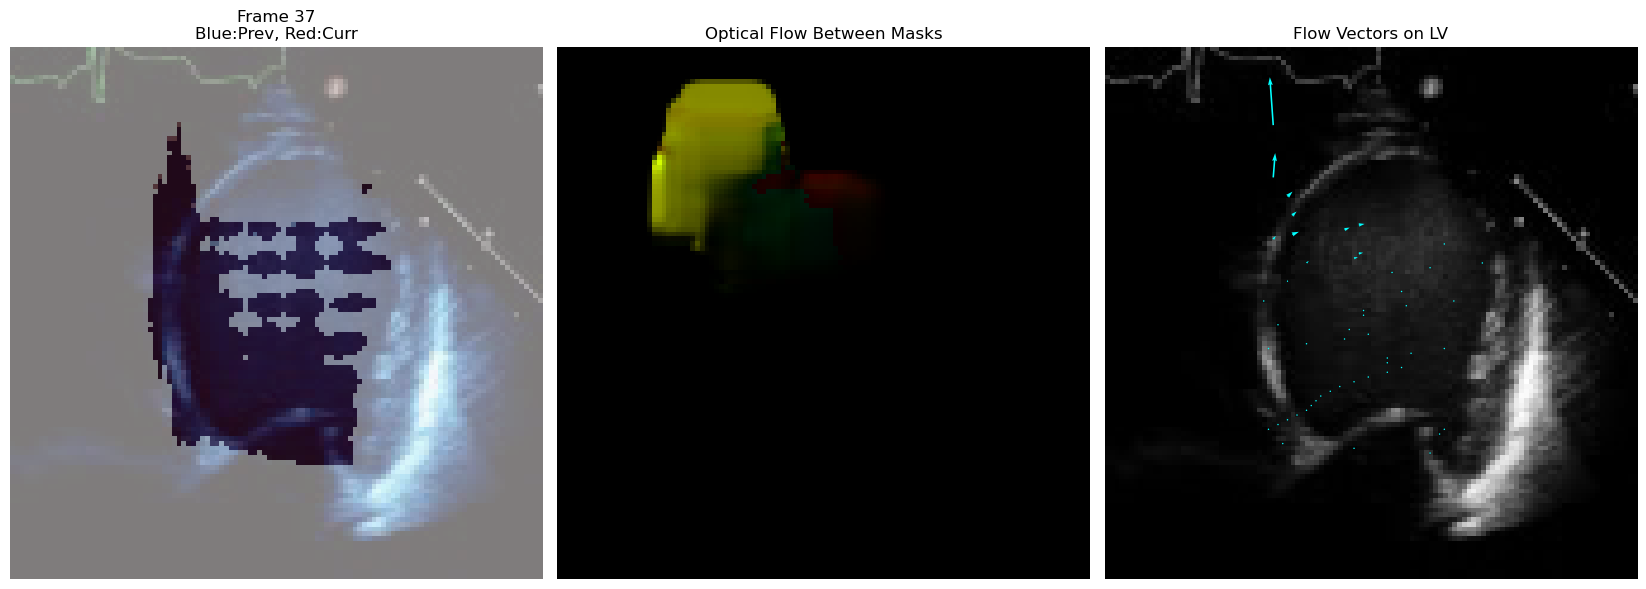


    ====== OPTICAL FLOW VALIDATION REPORT ======
    
    Input: ../data/raw/A4C/videos/CR32a7558-CR32a7585-000056.avi
    Frames Processed: 38
    Frames Compared: 37
    
    Validation Criteria:
      - Maximum Allowable Flow Magnitude: 2.5 pixels
    
    Results:
      - Valid Frames: 37 (100.0%)
      - Discarded Frames: 0
    
    Ejection Fraction Calculation:
      - EDV: 178.0 ml (Frame 0)
      - ESV: 149.0 ml (Frame 34)
      - EF: 16.3%
    
    Valid Frames Statistics:
      - Mean Flow Magnitude: 0.49 px
      - Mean Mask Area: 1900 px
    
    Valid Frame Indices: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
    


{'valid_frames': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37],
 'validation_metrics': [{'frame': 1,
   'mean_magnitude': 1.1466484,
   'is_valid': True,
   'mask_area': 2081},
  {'frame': 2,
   'mean_magnitude': 0.34045643,
   'is_valid': True,
   'mask_area': 2038},
  {'frame': 3,
   'mean_magnitude': 0.73781997,
   'is_valid': True,
   'mask_area': 1988},
  {'frame': 4,
   'mean_magnitude': 0.9920153,
   'is_valid': True,
   'mask_area': 1937},
  {'frame': 5,
   'mean_magnitude': 0.32219127,
   'is_valid': True,
   'mask_area': 1937},
  {'frame': 6,
   'mean_magnitude': 0.5223394,
   'is_valid': True,
   'mask_area': 1951},
  {'frame': 7,
   'mean_magnitude': 0.48908716,
   'is_valid': True,
   'mask_area': 1927},
  {'frame': 8,
   'mean_magnitude': 0.48887947,
   'is_valid': True,
   'mask_area': 1929},
  {'frame': 9,


In [333]:
validate_with_optical_flow("../data/raw/A4C/videos/CR32a7558-CR32a7585-000056.avi", model, device)